In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import sims
from networks import NetworkMaps, NetworkSensitivity, NetworkParamMap, NetworkParamList

## Figure 3 - Posteriors

Simulator

In [3]:
simulator = sims.ToyFermi(npix = 128)
shapes, dtypes = simulator.get_shapes_and_dtypes()
store = swyft.ZarrStore("/project/fermi_data/neurips_original_d.zarr")

def hook(out):
    N = int(out['pdp'][0])
    idx = torch.randint(N, (1,)) # index in simulated source range
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    # make sure to pick source simulated in image
    while torch.sum((out['source'][:2]>40)+(out['source'][:2]<-40), -1):
        idx = torch.randint(N, (1,)) # index in simulated source range
        out['source'] = torch.from_numpy(out['pdc'][idx]) # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    out['d_source'] = np.array([out['d'][idx]])*1. # (1,)   
    out = sl.to_numpy32(out)
    return out

dl_test = store.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample=hook)

trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_sensitivity/version_0/checkpoints/model.yaml")
network_d = NetworkSensitivity()
trainer.test(network_d, dl_test, ckpt_path = ckpt_path);

threshold= 10
psc_det = torch.tensor(np.load('neurips_ps_det.npy'))
bounds = sims.ToyFermiBound(detected = psc_det, threshold = threshold)
simulator = sims.ToyFermiSensitivity(npix = 128, bounds=bounds, sensitivity_function=network_d)

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.05293805152177811
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Targeted store

In [4]:
zs = swyft.ZarrStore(f"/project/fermi_data/neurips_bounded.zarr")
dl_train = zs.get_dataloader(idx_range = [0, 36000], batch_size = 32, num_workers = 8)
dl_val = zs.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8)

Load back NetworkParamMap

In [5]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu')
network_maps = NetworkMaps(lr=1e-3, lrs_factor = 0.1, lrs_patience = 3, early_stopping_patience = 5)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_detection/version_0/checkpoints/model.yaml")
trainer.test(network_maps, dl_val, ckpt_path = ckpt_path)

trainer_map = swyft.SwyftTrainer(accelerator = 'gpu')
network_param_map = NetworkParamMap(network_maps=network_maps)
ckpt_path = swyft.best_from_yaml(f"./lightning_logs/neurips_params_map/version_0/checkpoints/model.yaml")
trainer_map.test(network_param_map, dl_val, ckpt_path = ckpt_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Restoring states from the checkpoint path at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -929.2113037109375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/neurips_params_map/version_0/checkpoints/epoch=16-val_loss=-4.71.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_params_map/version_0/checkpoints/epoch=16-val_loss=-4.71.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -4.663394451141357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -4.663394451141357}]

Load back NetworkParamList

In [6]:
trainer_list = swyft.SwyftTrainer(accelerator = 'gpu')
network_param_list = NetworkParamList()
ckpt_path = swyft.best_from_yaml(f"./lightning_logs/neurips_params_list/version_0/checkpoints/model.yaml")
trainer_list.test(network_param_list, dl_val, ckpt_path = ckpt_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/neurips_params_list/version_0/checkpoints/epoch=13-val_loss=-5.36.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_params_list/version_0/checkpoints/epoch=13-val_loss=-5.36.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -5.315526008605957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -5.315526008605957}]

Infer

In [7]:
s0 = np.load('obs.npy', allow_pickle=True).item()
truth = {f'pdp[{i}]': s0['pdp'][i] for i in range(3)}
labeler = {'pdp[0]': r"$N$", 'pdp[1]': r"$\Sigma$", 'pdp[2]': "$h$"}
B = simulator.sample(100000, targets=['pdcc'])

100%|██████████████████████████████████| 100000/100000 [05:09<00:00, 322.74it/s]


Evaluate NetworkParamMap

${\color{orange}{ r_3(\boldsymbol{\vartheta}; \boldsymbol{x}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)}}$

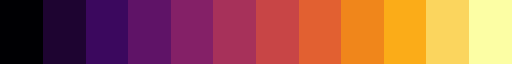

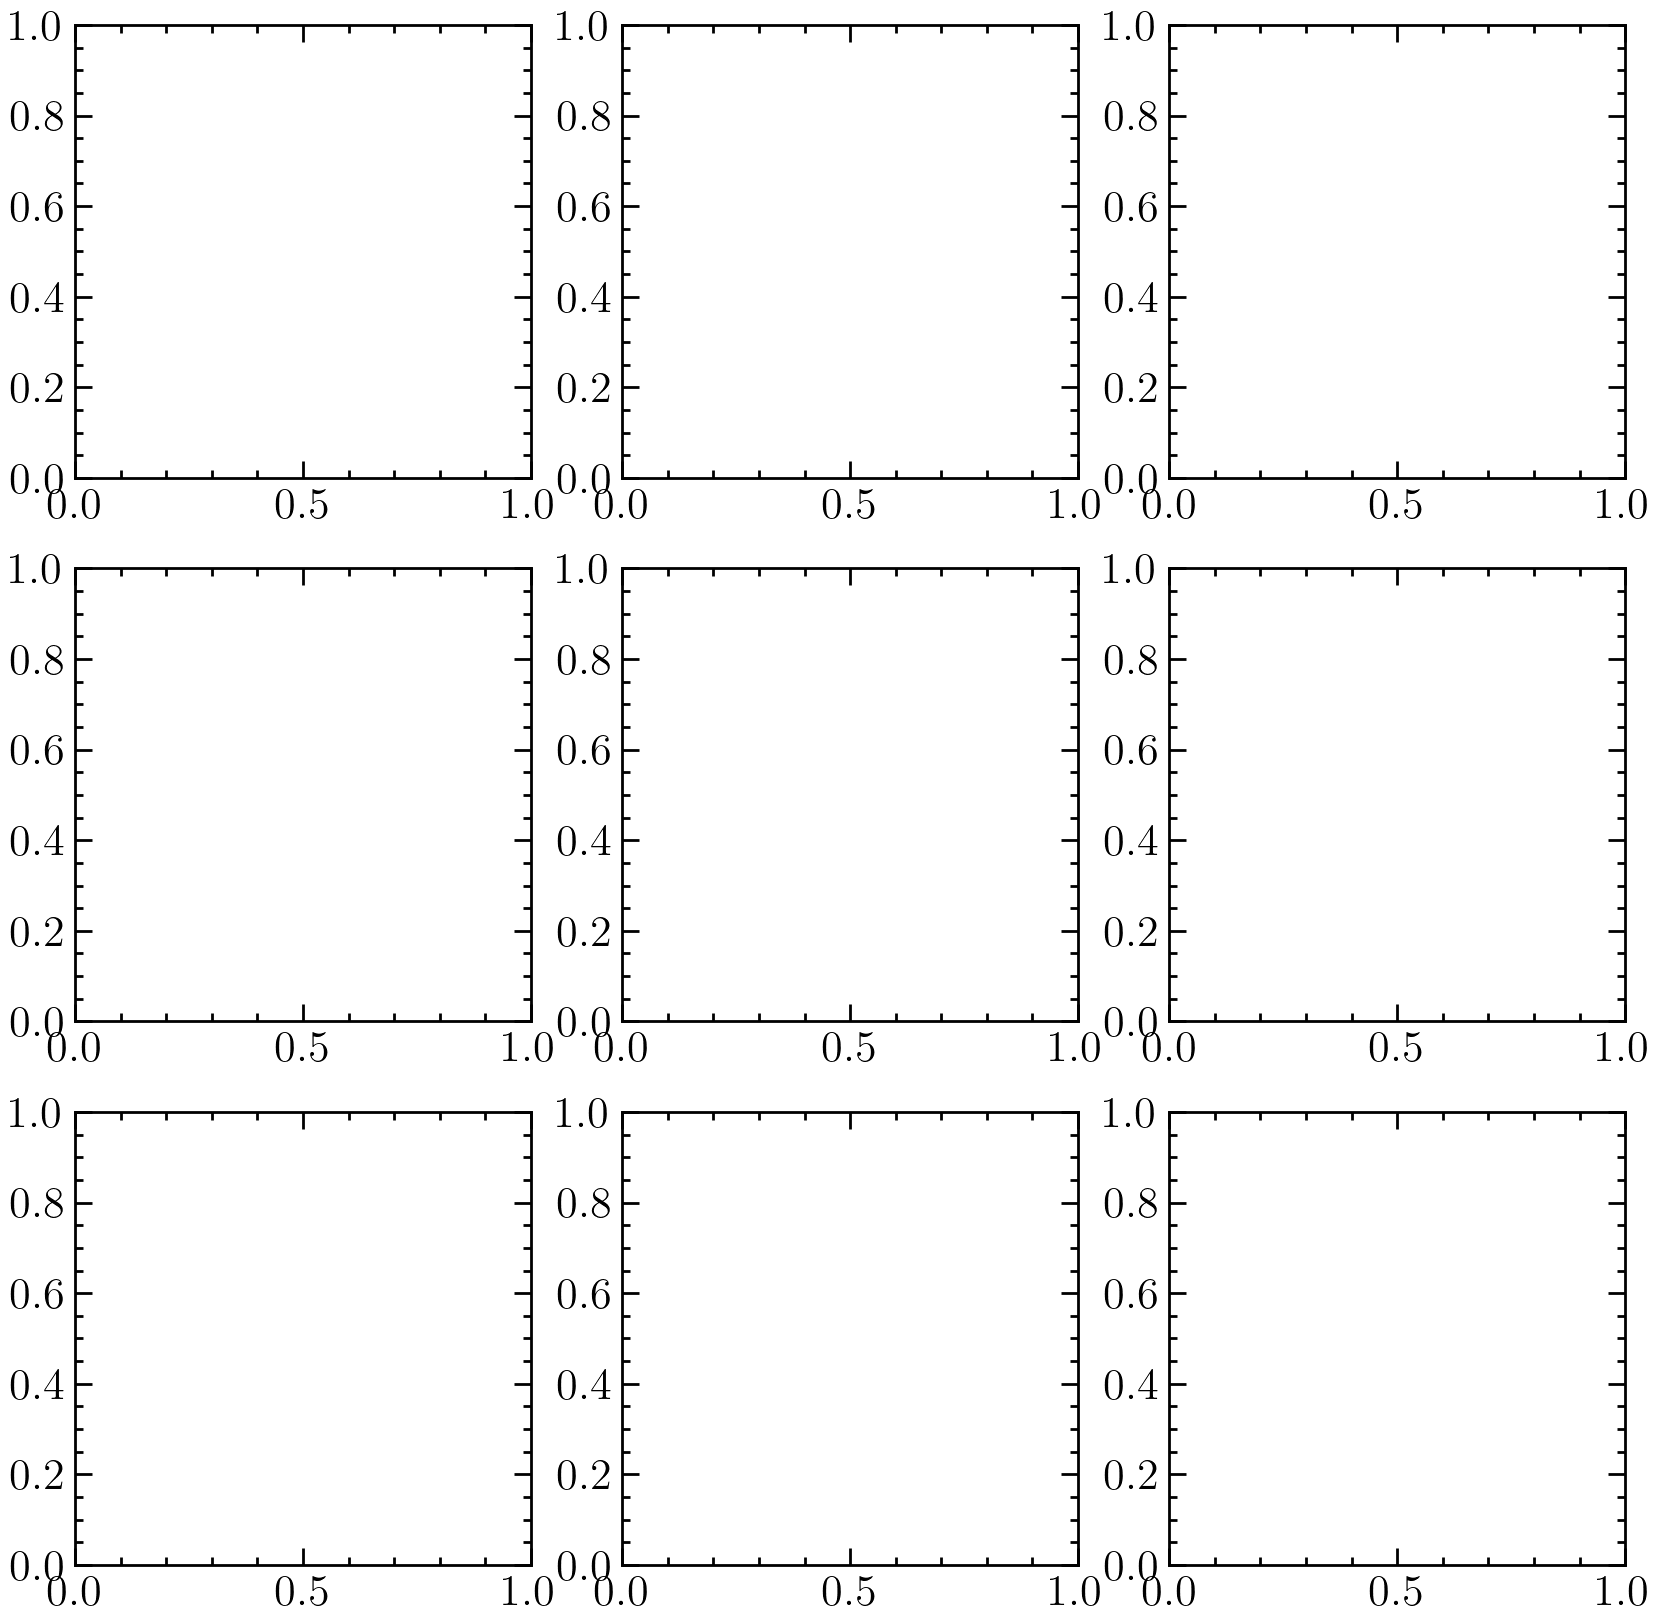

In [12]:
from matplotlib.colors import LinearSegmentedColormap, to_rgb

plt.style.use(['science', 'notebook'])
plt.rcParams.update({
"text.usetex": True,
# "font.family": "Helvetica",
# 'preamble':r'\usepackage{amsmath}'
})

fig, axes = plt.subplots(3, 3, figsize=(10,10), dpi=200);

cmap = plt.cm.inferno(np.linspace(0, 1, 6))
LinearSegmentedColormap.from_list("Custom", cmap, N=12)

In [13]:
A = swyft.Sample(s0)
out_map = trainer.infer(network_param_map, A, B)
swyft.corner((out_map['re_param'], out_map['re_param2'],), ('pdp[0]', 'pdp[1]', 'pdp[2]'), 
             truth=truth, labeler=labeler, contours_1d=False, 
             bins = 500, smooth = 15, color="#932667", fig=fig);

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Evaluate NetworkParamList

$
r(\boldsymbol{\vartheta}; \mathbb{I}(\vec{\boldsymbol{s}}_{det})=1) = 
\int d\vec{\boldsymbol{s}}_{det} 
\frac{p(\vec{\boldsymbol{s}}_{det}|\boldsymbol{\vartheta})} {p(\vec{\boldsymbol{s}}_{det})}
p(\vec{\boldsymbol{s}}_{det}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})= 1) = 
\int d\vec{\boldsymbol{s}}_{det} 
{\color{teal} {r_4(\vec{\boldsymbol{s}}_{det}; \boldsymbol{\vartheta})}}
p(\vec{\boldsymbol{s}}_{det}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})= 1)
$

In [14]:
A = simulator.sample(100000, targets=['pdcd'])
A['pdcr'] = A['pdcd'] # trick labels
out_list = trainer_list.infer(network_param_list, A, B)
swyft.corner((out_list['re_param'], out_list['re_param2'],), ('pdp[0]', 'pdp[1]', 'pdp[2]'), 
             truth=truth, labeler=labeler, contours_1d=False, 
             bins = 500, smooth = 15, color="#dd513a", fig=fig);

100%|█████████████████████████████████| 100000/100000 [00:58<00:00, 1708.95it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Samples from the full posterior $p(\boldsymbol{\vartheta}|\boldsymbol{x})$ by sampling $\boldsymbol{\vartheta}, \vec{\bf{s}}_{det} \sim p(\boldsymbol{\vartheta})p(\vec{\boldsymbol{s}}_{det}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)$
with weights
$w = {\color{orange}{ r_3(\boldsymbol{\vartheta}; \boldsymbol{x}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)}}\cdot
r(\boldsymbol{\vartheta}; \mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)
$.  

In [15]:
out = out_map
out['re_param'].logratios = (out_map['re_param'].logratios.exp() * out_list['re_param'].logratios.exp()).log()
out['re_param2'].logratios = (out_map['re_param2'].logratios.exp() * out_list['re_param2'].logratios.exp()).log()

In [16]:
# fig, axes = plt.subplots(3, 3, figsize=(10,10), dpi=200);

colors = [(1, 1, 1), to_rgb(cmap[4])] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("Custom", colors, N=20)

swyft.corner((out['re_param'], out['re_param2'],), ('pdp[0]', 'pdp[1]', 'pdp[2]'), 
             truth=truth, labeler=labeler, contours_1d=False, 
             bins = 500, smooth = 15, color="#fca50a", fig=fig, 
             solid=False, cmap=cm);

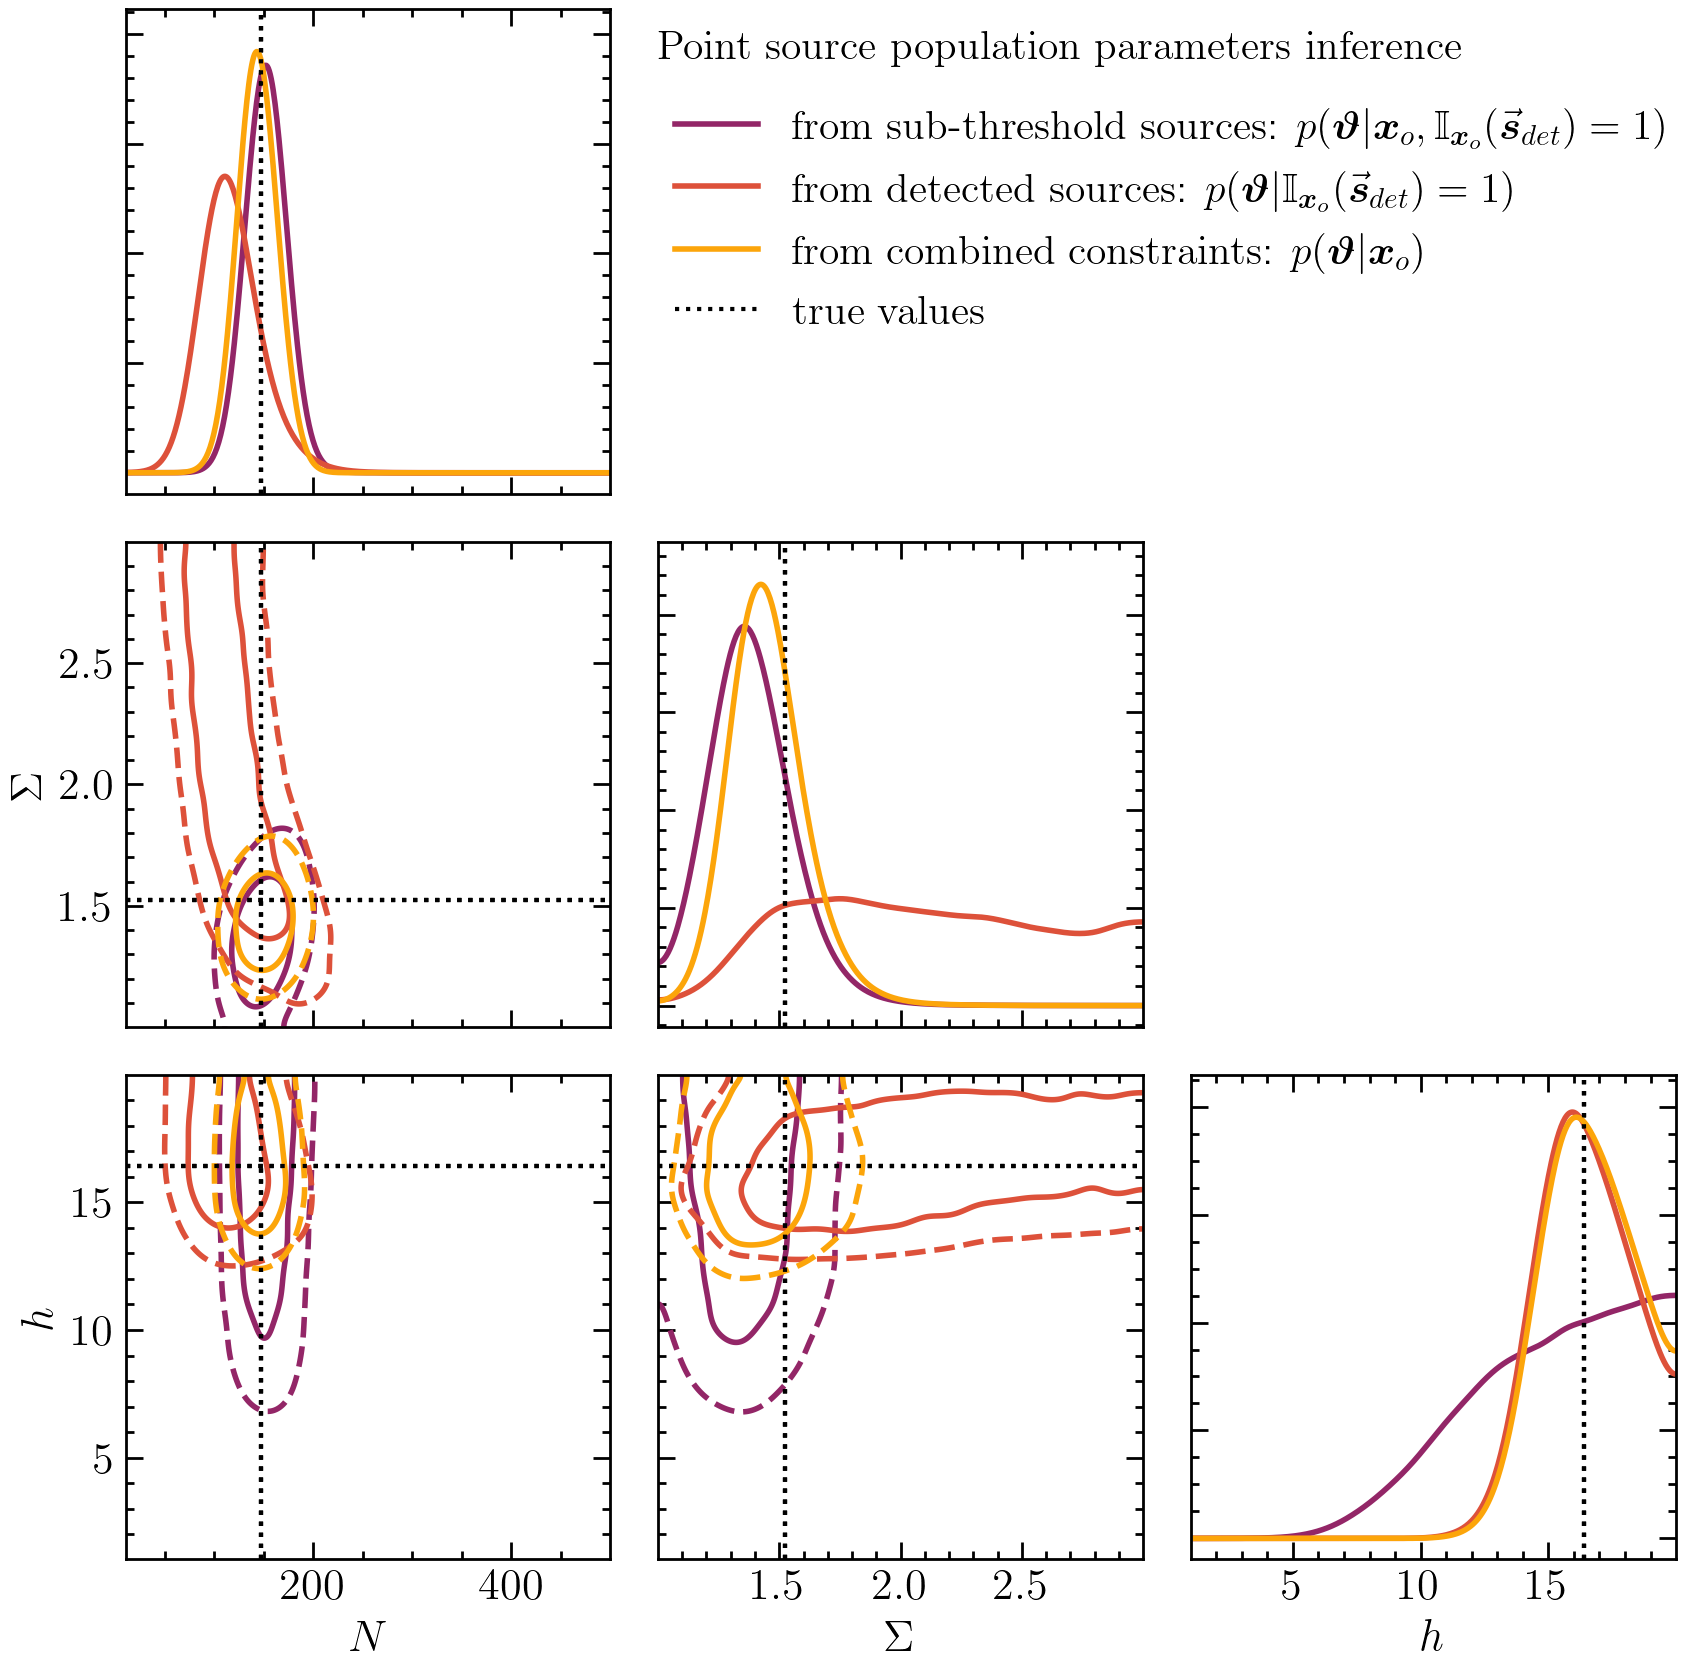

In [17]:
# fig, axes = plt.subplots(3, 3, figsize=(10,10), dpi=200);
axes[0,1].text(0,0.9, r'$\mathrm{Point\ source\ population\ parameters\ inference}$', fontsize=15)

axes[0,2].plot([],[], c=cmap[2], ls='-', lw=2,  
               label = r'$\mathrm{from\\\ sub}$-$\mathrm{threshold\\\ sources}$: $p(\boldsymbol{\vartheta}| \boldsymbol{x}_o, \mathbb{I}_{\boldsymbol{x}_o}(\vec{\boldsymbol{s}}_{det})=1)$')

axes[0,2].plot([],[], c=cmap[3], ls='-', lw=2,  
               label = r'$\mathrm{from\\\ detected\\\ sources}$: $p(\boldsymbol{\vartheta}| \mathbb{I}_{\boldsymbol{x}_o}(\vec{\boldsymbol{s}}_{det})=1)$')

axes[0,2].plot([],[], c=cmap[4], ls='-', lw=2,  
               label = r'$\mathrm{from\\\ combined\\\ constraints}$: $p(\boldsymbol{\vartheta} | \boldsymbol{x}_o)$')


axes[0,2].plot([],[], c='k', ls=':', label = r'$\mathrm{true\\\ values}$', lw=1.5)
axes[0,2].legend(loc=(-1.1, 0.3), fontsize=15)
fig